In [348]:
# !pip install gender_guesser
# !pip install missingno
!pip install wordcloud

In [349]:
import pandas as pd
import gender_guesser.detector as gender
from sklearn import preprocessing
import random
import nltk
import re
import string
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob

from textblob import Word
st = PorterStemmer()
stop = stopwords.words('english')

In [350]:
DataFrame = pd.read_csv('Yelp_Business_Reviews1.csv')

In [351]:
DataFrame.shape

(664, 25)

In [352]:
DataFrame.head()

,Unnamed: 0,Business_Name,Business_Address,Business_ReviewCount,Business_Rating,Business_Photos_Count,Business_Timings,Business_Claim_status,Customer_Name,Customer_Friends_count,...,Customer_Review,Customer_Review_Date,Customer_Review_Uploaded_Photos,Customer_Review_Useful,Customer_Review_Funny,Customer_Review_Cool,Business_response_By,Business_response_Date,Business_Response_for_Review,Business_Response
0,0,Wiggy's Plumbing,"Midwest City, OK 73140",4,5.0,NaN,NaN,NaN,Jj P.,3,...,I've used Wiggy's twice and I have been very g...,8/18/2017,0,3,0,0,NaN,NaN,NaN,0
1,1,Wiggy's Plumbing,"Midwest City, OK 73140",4,5.0,NaN,NaN,NaN,John C.,1,...,My new go to plumbing company. I had a water l...,6/26/2020,0,0,0,0,NaN,NaN,NaN,0
2,2,Wiggy's Plumbing,"Midwest City, OK 73140",4,5.0,NaN,NaN,NaN,Vickie C.,0,...,I've had the occasion to use Wiggy's Plumbing ...,10/24/2019,0,0,0,0,NaN,NaN,NaN,0
3,3,Wiggy's Plumbing,"Midwest City, OK 73140",4,5.0,NaN,NaN,NaN,Lenny K.,1,...,Best plumber in the state do I need to say mor...,1/19/2017,First,1,0,0,NaN,NaN,NaN,0
4,0,Henslee's Plumbing Heating and Air,"Oklahoma City, OK 73157",2,5.0,NaN,NaN,NaN,Roger L.,0,...,Chris Henslee is the best man I've ever known ...,5/21/2018,0,1,0,0,NaN,NaN,NaN,0


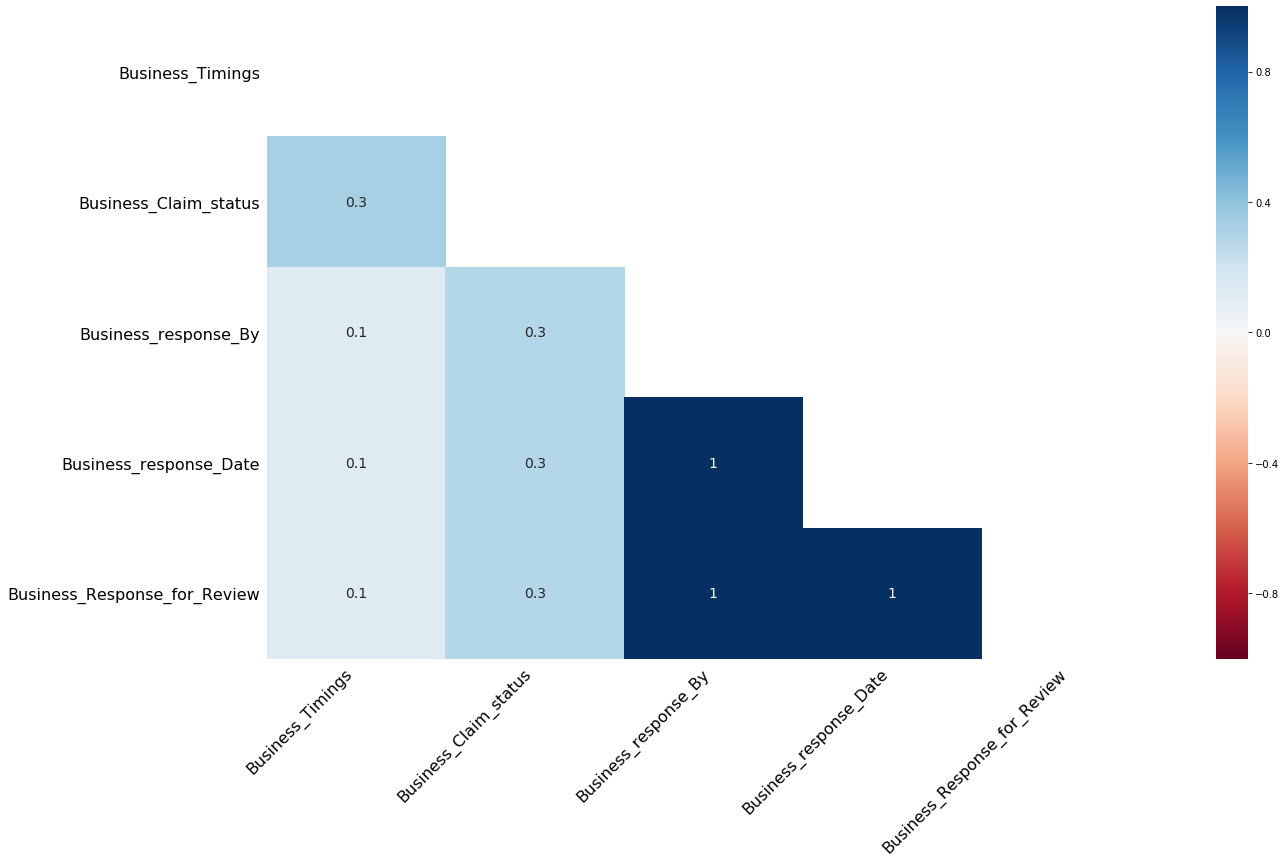

In [353]:
import missingno as msno
df = pd.read_csv('Yelp_Business_Reviews1.csv')
msno.heatmap(df)


In [354]:
DataFrame.isna().sum()

Unnamed: 0                           0
Business_Name                        0
Business_Address                     0
Business_ReviewCount                 0
Business_Rating                      0
Business_Photos_Count              664
Business_Timings                   114
Business_Claim_status              382
Customer_Name                        0
Customer_Friends_count               0
Customer_Reviews_count               0
Customer_Photos_count                0
Customer_Elite                       0
Customer_Elite_Year                  0
Customer_Rating                      0
Customer_Review                      0
Customer_Review_Date                 0
Customer_Review_Uploaded_Photos      0
Customer_Review_Useful               0
Customer_Review_Funny                0
Customer_Review_Cool                 0
Business_response_By               613
Business_response_Date             613
Business_Response_for_Review       613
Business_Response                    0
dtype: int64

In [355]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 25 columns):
Unnamed: 0                         664 non-null int64
Business_Name                      664 non-null object
Business_Address                   664 non-null object
Business_ReviewCount               664 non-null int64
Business_Rating                    664 non-null float64
Business_Photos_Count              0 non-null float64
Business_Timings                   550 non-null object
Business_Claim_status              282 non-null object
Customer_Name                      664 non-null object
Customer_Friends_count             664 non-null int64
Customer_Reviews_count             664 non-null int64
Customer_Photos_count              664 non-null int64
Customer_Elite                     664 non-null object
Customer_Elite_Year                664 non-null object
Customer_Rating                    664 non-null int64
Customer_Review                    664 non-null object
Customer_Review_Date 

## Feature Engineering

In [356]:
# dropping Business_response_By, Business_response_Date, Business_Response_for_Review
DataFrame.drop('Business_response_By', axis=1, inplace=True)
DataFrame.drop('Business_response_Date', axis=1, inplace=True)
DataFrame.drop('Business_Response_for_Review', axis=1, inplace=True)

# dropping Business_Photos_Count
DataFrame.drop('Business_Photos_Count', axis=1, inplace=True)

In [357]:
# Business_Name Customer_Name
# label encoder 
def label_encoder(DataFrame, column):  
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column  
    DataFrame[column]= label_encoder.fit_transform(DataFrame[column]) 
    return DataFrame

DataFrame =label_encoder(DataFrame, 'Business_Name')
DataFrame =label_encoder(DataFrame, 'Customer_Elite')
# DataFrame.head()

In [358]:
# Business Address
def get_state(address):
    state = address.split(" ")[-2]
    return state
def get_zipcode(address):
    zipcode = address.split()[-1]
    return zipcode

DataFrame['Business_State'] = DataFrame['Business_Address'] .apply(get_state) 
DataFrame['Business_Zipcode'] = (DataFrame['Business_Address'] .apply(get_zipcode))
DataFrame =label_encoder(DataFrame, 'Business_State')
DataFrame =label_encoder(DataFrame, 'Business_Zipcode')

# dropping Business_Address
DataFrame.drop('Business_Address', axis=1, inplace=True)


In [359]:
#Business_ReviewCount               
# Business_Rating  

# Business_Timings  

def Handle_timings_from(time):        
    if '-' in str(time):
        time_from =str(time).split('-')[0]
        time_from= time_from.split(':')[0]   
        return time_from
    
    else:
        time_from = ''.join(filter(str.isdigit, str(time)))
        return time_from

def Handle_timings_to(time):    
    if '-' in str(time):
        time_to =str(time).split('-')[1]
        time_to= time_to.split(':')[0]  
        return time_to
    else:
        time_to = ''.join(filter(str.isdigit, str(time)))
        return time_to

# Handling Timings column and replacing na values in Business_Timings_From  with 0
DataFrame['Business_Timings_From']= DataFrame['Business_Timings'] .apply(Handle_timings_from) 
DataFrame['Business_Timings_From'] = DataFrame['Business_Timings_From'] .replace(to_replace ='', value =0)


# Handling Timings column and replacing na values in Business_Timings_to  with 0
DataFrame['Business_Timings_To']= DataFrame['Business_Timings'] .apply(Handle_timings_to)
DataFrame['Business_Timings_To'] = DataFrame['Business_Timings_To'].replace(to_replace ='', value =0)

# dropping Business_Timings
DataFrame.drop('Business_Timings', axis=1, inplace=True)

In [360]:
# Business_Claim_status
DataFrame['Business_Claim_status'] = DataFrame['Business_Claim_status'].fillna(0)
DataFrame['Business_Claim_status'] = DataFrame['Business_Claim_status'].replace(to_replace ='Claimed', value =1)

# Converting the Customer_Name column to gender based on names
def Converting_Names_to_gender(name):
    name =str(name).split()[0]
    d = gender.Detector()
    gender_type = d.get_gender(name)
    return gender_type

DataFrame['Customer_Name'] = DataFrame['Customer_Name'].apply(Converting_Names_to_gender)
# DataFrame.head()
DataFrame =label_encoder(DataFrame, 'Customer_Name')                             
# Customer_Elite_Year 
DataFrame.drop('Customer_Elite_Year', axis=1, inplace=True)
# DataFrame.head()
               

In [361]:
# function to remove the unwanted text in Date column 
def cleaning_Business_date(date):
    date = str(date).split('U')[0]
    return date

# function to handle the date column in the data frame
def Handling_time_feature(DataFrame,column):
    # splitting the time feature into seperate features
    DataFrame[column + '_year'] = pd.DatetimeIndex(DataFrame[column]).year
    DataFrame[column +'_month'] = pd.DatetimeIndex(DataFrame[column]).month
    DataFrame[column +'_day'] = pd.DatetimeIndex(DataFrame[column]).day
    DataFrame= DataFrame.drop(columns=[column], axis=0) # dropping the date column 
    return DataFrame

# Updating the Date Columns
DataFrame['Customer_Review_Date'] = DataFrame['Customer_Review_Date'].apply(cleaning_Business_date)
# DataFrame['Business_response_Date'] = DataFrame['Business_response_Date'].apply(cleaning_Business_date)

# calling the Handling_time_feature() to split the timestamp feature into seperate features
DataFrame = Handling_time_feature(DataFrame, 'Customer_Review_Date')
# DataFrame = Handling_time_feature(DataFrame, 'Business_response_Date')
# DataFrame.head()

In [362]:
DataFrame.head()


,Unnamed: 0,Business_Name,Business_ReviewCount,Business_Rating,Business_Claim_status,Customer_Name,Customer_Friends_count,Customer_Reviews_count,Customer_Photos_count,Customer_Elite,...,Customer_Review_Funny,Customer_Review_Cool,Business_Response,Business_State,Business_Zipcode,Business_Timings_From,Business_Timings_To,Customer_Review_Date_year,Customer_Review_Date_month,Customer_Review_Date_day
0,0,163,4,5.0,0,5,3,92,16,0,...,0,0,0,1,46,0,0,2017,8,18
1,1,163,4,5.0,0,2,1,22,2,0,...,0,0,0,1,46,0,0,2020,6,26
2,2,163,4,5.0,0,1,0,2,0,0,...,0,0,0,1,46,0,0,2019,10,24
3,3,163,4,5.0,0,2,1,4,0,0,...,0,0,0,1,46,0,0,2017,1,19
4,0,77,2,5.0,0,2,0,1,0,0,...,0,0,0,1,52,0,0,2018,5,21


In [363]:
# Customer_Uploaded_Photos
DataFrame['Customer_Review_Uploaded_Photos'] = DataFrame['Customer_Review_Uploaded_Photos'].replace(to_replace =['First','ROTD'], value =-1)

In [364]:
# Function to clean the text
def text_cleaning(review):    
    review = review.lower()
    review = review.strip()
    review = re.sub(r'[0-9]', '', review)   
    review = "".join([word for word in review if word not in string.punctuation])
    # spelling correct
    review = TextBlob(review).correct()
    # Lemmatize final review format
    review =  "".join([Word(word).lemmatize() for word in review])
    
    return review
    
# Text cleaning of customer Review
DataFrame['Cleaned_Customer_Review'] = DataFrame['Customer_Review'].apply(text_cleaning)


# Calculate word count
DataFrame['review_word_count'] = DataFrame['Customer_Review'].apply(lambda x: len(str(x).split(" ")))
# Calculate character count
DataFrame['review_char_count'] = DataFrame['Customer_Review'].str.len()


def avg_word(review):
    words = review.split()
    return (sum(len(word) for word in words) / len(words))

# Calculate average words
DataFrame['review_avg_word_length'] = DataFrame['Customer_Review'].apply(lambda x: avg_word(x))

###  Sentiment Analysis of Customer Review

In [365]:
# Calculate polarity
DataFrame['polarity'] = DataFrame['Cleaned_Customer_Review'].apply(lambda x: TextBlob(x).sentiment[0])

# Calculate subjectivity
DataFrame['subjectivity'] = DataFrame['Cleaned_Customer_Review'].apply(lambda x: TextBlob(x).sentiment[1])

# negative, nautral, positive analysis
def getTextAnalysis(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
    
DataFrame['Sentiment_Score'] = DataFrame['polarity'].apply(getTextAnalysis)

DataFrame =label_encoder(DataFrame, 'Sentiment_Score')


In [366]:
DataFrame[[ 'review_word_count',  'review_char_count', 'review_avg_word_length', 'polarity' , 'subjectivity','Sentiment_Score']].head()

,review_word_count,review_char_count,review_avg_word_length,polarity,subjectivity,Sentiment_Score
0,116,623,4.379310,0.155556,0.477778,2
1,47,247,4.276596,0.253939,0.484242,2
2,66,390,4.863636,0.456250,0.656250,2
3,39,173,3.435897,0.750000,0.400000,2
4,33,189,4.757576,0.337500,0.612500,2


In [367]:
DataFrame.head()

,Unnamed: 0,Business_Name,Business_ReviewCount,Business_Rating,Business_Claim_status,Customer_Name,Customer_Friends_count,Customer_Reviews_count,Customer_Photos_count,Customer_Elite,...,Customer_Review_Date_year,Customer_Review_Date_month,Customer_Review_Date_day,Cleaned_Customer_Review,review_word_count,review_char_count,review_avg_word_length,polarity,subjectivity,Sentiment_Score
0,0,163,4,5.0,0,5,3,92,16,0,...,2017,8,18,give used wings twice and i have been very gra...,116,623,4.379310,0.155556,0.477778,2
1,1,163,4,5.0,0,2,1,22,2,0,...,2020,6,26,my new go to plunging company i had a water le...,47,247,4.276596,0.253939,0.484242,2
2,2,163,4,5.0,0,1,0,2,0,0,...,2019,10,24,give had the occasion to use wings plunging se...,66,390,4.863636,0.456250,0.656250,2
3,3,163,4,5.0,0,2,1,4,0,0,...,2017,1,19,best plumber in the state do i need to say mor...,39,173,3.435897,0.750000,0.400000,2
4,0,77,2,5.0,0,2,0,1,0,0,...,2018,5,21,chris henslee is the best man give ever known ...,33,189,4.757576,0.337500,0.612500,2


In [368]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [369]:
def wordcloud_by_province(reviews):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in reviews.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Business Reviews by Customers")

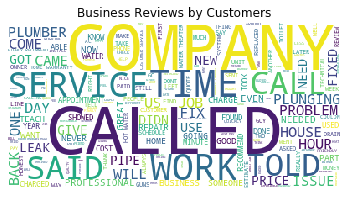

In [370]:
wordcloud_by_province(DataFrame['Cleaned_Customer_Review'])  

# Dropping the Cleaned_Customer_Review

DataFrame.drop('Cleaned_Customer_Review', axis=1, inplace=True)
DataFrame.drop('Customer_Review', axis=1, inplace=True)

In [377]:
DataFrame.isna().sum()

Unnamed: 0                         0
Business_Name                      0
Business_ReviewCount               0
Business_Rating                    0
Business_Claim_status              0
Customer_Name                      0
Customer_Friends_count             0
Customer_Reviews_count             0
Customer_Photos_count              0
Customer_Elite                     0
Customer_Rating                    0
Customer_Review_Uploaded_Photos    0
Customer_Review_Useful             0
Customer_Review_Funny              0
Customer_Review_Cool               0
Business_Response                  0
Business_State                     0
Business_Zipcode                   0
Business_Timings_From              0
Business_Timings_To                0
Customer_Review_Date_year          0
Customer_Review_Date_month         0
Customer_Review_Date_day           0
review_word_count                  0
review_char_count                  0
review_avg_word_length             0
polarity                           0
s

In [375]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 29 columns):
Unnamed: 0                         664 non-null int64
Business_Name                      664 non-null int32
Business_ReviewCount               664 non-null int64
Business_Rating                    664 non-null float64
Business_Claim_status              664 non-null int64
Customer_Name                      664 non-null int32
Customer_Friends_count             664 non-null int64
Customer_Reviews_count             664 non-null int64
Customer_Photos_count              664 non-null int64
Customer_Elite                     664 non-null int32
Customer_Rating                    664 non-null int64
Customer_Review_Uploaded_Photos    664 non-null object
Customer_Review_Useful             664 non-null int64
Customer_Review_Funny              664 non-null int64
Customer_Review_Cool               664 non-null int64
Business_Response                  664 non-null int64
Business_State              

In [376]:
DataFrame.apply(pd.to_numeric).head()

,Unnamed: 0,Business_Name,Business_ReviewCount,Business_Rating,Business_Claim_status,Customer_Name,Customer_Friends_count,Customer_Reviews_count,Customer_Photos_count,Customer_Elite,...,Business_Timings_To,Customer_Review_Date_year,Customer_Review_Date_month,Customer_Review_Date_day,review_word_count,review_char_count,review_avg_word_length,polarity,subjectivity,Sentiment_Score
0,0,163,4,5.0,0,5,3,92,16,0,...,0,2017,8,18,116,623,4.379310,0.155556,0.477778,2
1,1,163,4,5.0,0,2,1,22,2,0,...,0,2020,6,26,47,247,4.276596,0.253939,0.484242,2
2,2,163,4,5.0,0,1,0,2,0,0,...,0,2019,10,24,66,390,4.863636,0.456250,0.656250,2
3,3,163,4,5.0,0,2,1,4,0,0,...,0,2017,1,19,39,173,3.435897,0.750000,0.400000,2
4,0,77,2,5.0,0,2,0,1,0,0,...,0,2018,5,21,33,189,4.757576,0.337500,0.612500,2


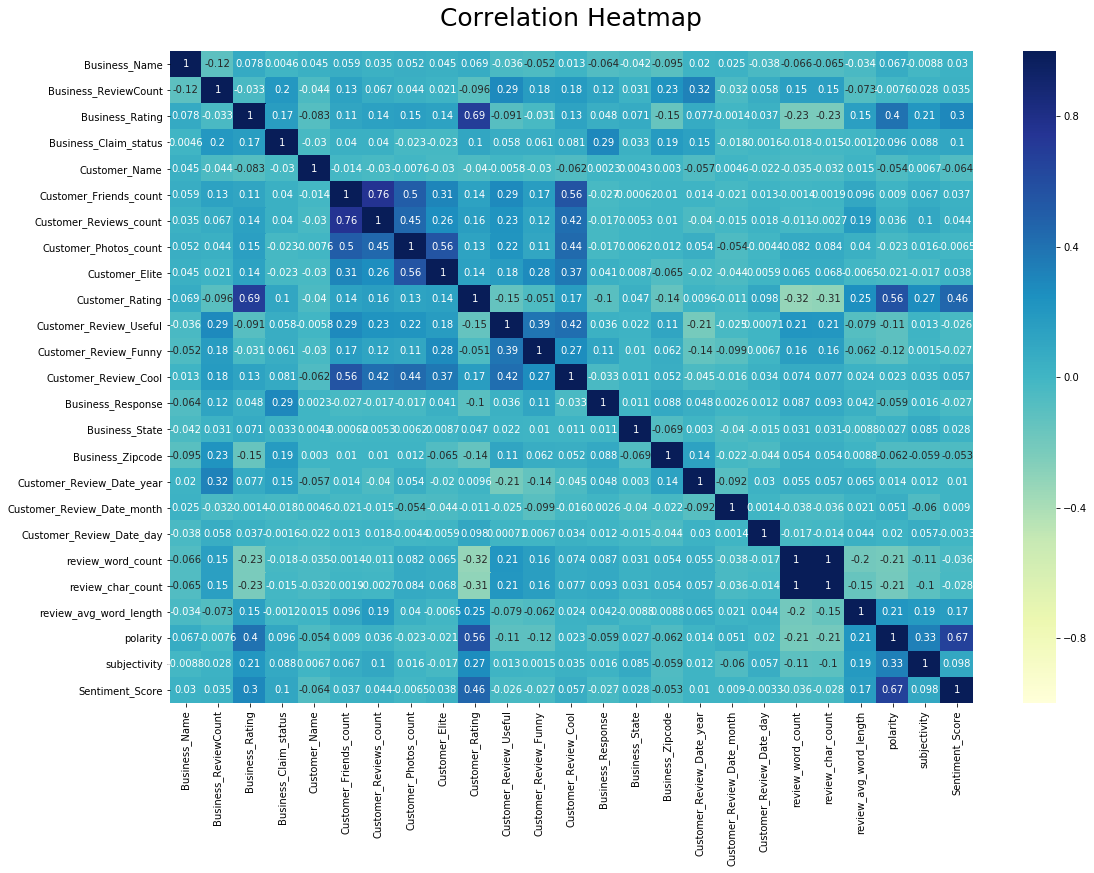

In [388]:
DataFrame.drop('Unnamed: 0', axis=1, inplace=True)
plt.figure(figsize=(18, 12))
heatmap = sns.heatmap(DataFrame.corr(), vmin=-1, vmax=1, annot=True, cmap= 'YlGnBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':25}, pad=25);

# Modeling

In [380]:
from sklearn.model_selection import train_test_split

# splitting the data frame into Features and Target varibale for Testing  and Training the model 
X = DataFrame.drop(columns=['Business_Response'], axis=0)
y = DataFrame['Business_Response']
X_train, X_test, y_train, y_test = train_test_split(DataFrame, y, test_size=0.30, random_state=42)
print(DataFrame.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(664, 29)
(464, 29)
(200, 29)
(464,)
(200,)


In [382]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  
# define the model
model = RandomForestClassifier()
# fit the model on the whole dataset
model.fit(X_train, y_train)


#performing predictions on the test dataset
y_pred = model.predict(X_test)



C:\Users\Prudhvi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [383]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.995


In [385]:
print(metrics.confusion_matrix(y_test, y_pred))

[[182   0]
 [  1  17]]


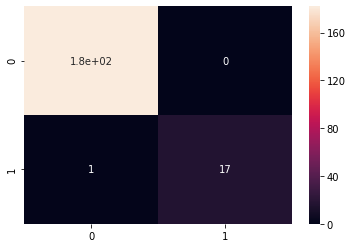

In [386]:
import seaborn as sns
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)